# Match _All_ The Things: Deduplication, Record Linkage, and Entity Resolution in Python

If you work in the data business, you'll eventually find yourself trying to make an approximate match from one data source to another.  This comes in at least three flavors: _searching_, where a user-supplied name is matched against a database (for example, auto-complete); _joining_ or [_record linkage_](http://en.wikipedia.org/wiki/Record_linkage), where you're trying to join datasets like you would with a relational join except based on an approximate criteria; and _deduplication_ or _clustering_, where you're trying to group items from one source based on similarity.  The general problem of trying to determine if two records refer to the same entity is called _entity resolution_.

These tasks are sometimes performed with a SQL database or some other information retrieval system (eg, Solr). But there are situations where we need something slightly different than the normal database management system, or we just want something simpler that doesn't require a separate deployment.

Table of Contents

1. [The Matching Problem](#The-Matching-Problem)
1. Exploring Your Data
2. [String Similarity and Distance](#String-Similarity-and-Distance)
  1. [Basic Python](#Basic-Python)
  1. Difflib
  1. Levenshtein
  1. Jaro/Jaro-Winkler
  1. Jaccard
  2. Metrics
  4. Token-Based Matching
    1. [N-Grams/Shingling](#N-Grams/Shingling)
    1. TF/IDF
    1. SoftTf-Idf
    2. Gayle-Shapley
  4. Matching Non-Text Data
3. Blocking
  1. Using a Single Property
  1. Using Multiple Properties
  1. N-Gram Based Blocking
  1. Canopy Clustering
4. Classifying Matches
  1. Probablistic Matching and Fellegi-Sunter
    1. The EM Algorithm
  1. Blocking
    5. Locality-Sensitive Hashing
      1. Minhash
6. Semantic Matching
  1. Human Names
6. Nearest-Neighbor
  1. kd-Trees
6. Pairwise alignment/Needleman-Wunsch
6. Entropy, Mutual Information, Kulbach-Liebler
6. Radix Tree/Patricia Trie
6. Entity Recognition/CRF
6. [References](#References)

## The Matching Problem

If you have two sets of data items, A and B, each with no duplicates then 

$$
M=\{ (a,b)| a \in A, b \in B, a = b \}
$$

$$
U=\{ (a,b)| a \in A, b \in B, a \ne b \}
$$

By definition the union of the two sets M and U is the set of all pairs A and B, or:

$$
A \times B = M \cup U
$$

Some notes:
- Formally the "=" indicates a true match.  In most real data sources, some non-matches will be spuriously classified as in the M set and some true matches will be put in the U set.
- The vast majority of pairs in A x B will be in __U__.  If A and B both have 1000 members, A x B will have 1 million pairs, but __M__ can have at most 1000 elements.
- Ideally if (a,b) and (b,c) are in __M__ then (a,c) should be also.  However, there are some methods that do not result in this _transitive closure_ and so extra logic might be need to find transitive associations.
- In the deduplication case there is only one dataset (A) so you consider all of the pairs (a1,a2) in A x A except where a1 and a2 are the same item.  In this case the __M__ set contains the duplicates.  There may be numerous pairs that all refer to the same entity, so again extra work here is require to cluster the duplicates into groups and select the best attributes to retain.

## Exploring Your Data

The first step in matching is to identify fields that can be used to link sources.  These are usually elements of the identity of the item, such as name, address or SSN.  However, they can be other properties that change with time such as age, assets in an account, or number of children.  Beyond merely locating such identifiers we also need to see if they are used consistently.  If a field is often left blank it might not be useful for linking source, or if it was originally entered by hand it might have mistakes in value or format.  This type of analysis is an aspect of what's sometimes called _data profiling_.

### Example 1: Examine a single source to find identifiers.

For an example, we'll use a file from the Department of Labor's website.  This is data from Schedule C of Form 5500, a form that must be filed each year by companies that sponsor defined contribution (ie 401k) plans for their employees.  Schedule C has the name of service providers that receive fees from the plan.  Here i'll load the file into a pandas Dataframe, and use various pandas tools to examine the data.  Our objective is to find identifiers for those service providers.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df=pd.read_csv('./data/F_SCH_C_PART1_ITEM1_2014_all.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29147 entries, 0 to 29146
Data columns (total 15 columns):
ACK_ID                            29147 non-null object
ROW_ORDER                         29147 non-null int64
PROVIDER_ELIGIBLE_NAME            29135 non-null object
PROVIDER_ELIGIBLE_EIN             18256 non-null float64
PROVIDER_ELIGIBLE_US_ADDRESS1     12531 non-null object
PROVIDER_ELIGIBLE_US_ADDRESS2     2550 non-null object
PROVIDER_ELIGIBLE_US_CITY         12531 non-null object
PROVIDER_ELIGIBLE_US_STATE        12531 non-null object
PROVIDER_ELIGIBLE_US_ZIP          12531 non-null float64
PROV_ELIGIBLE_FOREIGN_ADDRESS1    54 non-null object
PROV_ELIGIBLE_FOREIGN_ADDRESS2    8 non-null object
PROV_ELIGIBLE_FOREIGN_CITY        54 non-null object
PROV_ELIGIBLE_FOREIGN_PROV_ST     25 non-null object
PROV_ELIGIBLE_FOREIGN_CNTRY       54 non-null object
PROV_ELIGIBLE_FOREIGN_POST_CD     37 non-null object
dtypes: float64(2), int64(1), object(12)
memory usage: 3.6+ MB


The dataframe _info()_ method gives us both the names of the columns and the number of non-null values.  There are about 30k rows, but fewer than half have address information.  The PROVIDER\_ELIGIBLE\_EIN columns contains the Employer Identification Number (EIN) that the firm is assigned by the IRS, so that would seem to be a good matching candidate but it's only available for about 60% of the records.  The only identifier present for almost all records though is PROVIDER\_ELIGIBLE\_NAME.  Let't look at name individually using the pandas Series method _value_counts_

In [2]:
df.PROVIDER_ELIGIBLE_NAME.value_counts(dropna=False).head(10)

FIDELITY INVESTMENTS INSTITUTIONAL     2106
PRINCIPAL LIFE INSURANCE COMPANY       1107
AMERICAN FUNDS                          605
ALLIANZ GLOBAL INVESTORS DISTRIBUTO     527
T. ROWE PRICE                           485
PIMCO                                   420
THE VANGUARD GROUP, INC.                415
VANGUARD                                400
OPPENHEIMER FUNDS INC.                  368
GOLDMAN SACHS                           368
Name: PROVIDER_ELIGIBLE_NAME, dtype: int64

This tells us a couple of things.  First, some companies are referenced many times.  In this case, we probably knew that but in general this might reveal duplicates.  Second, this tells us that the same name is often used to reference this entity, which is usually good for cases of matching and de-duplication.

It's usually not a good idea to assume that the name is an unambiguous identifier for an entity though, so let's move on to our second-most frequent identifier, the EIN.   The info display also gives us another data point, which is that the PROVIDER\_ELIGIBLE\_EIN column has the type _float64_, indicating that all non-null values are numeric.  EINs are sometimes entered with a &dash; between parts of the number, so this suggests that data has already been processed to some extent.  We also expect EINs to be a 9 digit number.  Here's a handy trick to find the distinct numeric patterns in fields that are all or partially numeric (ie, containing dashes or prefixes).

In [3]:
t={ord(x): y for (x, y) in zip('0123456789', '9999999999')}
df['EINpat'] =  df.PROVIDER_ELIGIBLE_EIN.apply(lambda x: str(int(x)).translate(t) if pd.notnull(x) else 'NONE')
df.groupby('EINpat').count()['ACK_ID']

EINpat
99999999      4417
999999999    13839
NONE         10891
Name: ACK_ID, dtype: int64

Of the records that do have an EIN, about a quarter are only 8 digits.  Although it might not be obvious, this is often a clue that you have a numeric field with occasional leading 0s.  To check, let's reload the dataframe, specifying that the EIN column should be a string, and then reapply the pattern generator:

In [4]:
df=pd.read_csv('./data/F_SCH_C_PART1_ITEM1_2014_all.csv', dtype={'PROVIDER_ELIGIBLE_EIN': 'object'})

df['EINpat'] =  df.PROVIDER_ELIGIBLE_EIN.apply(lambda x: x.translate(t) if pd.notnull(x) else 'NONE')
df.groupby('EINpat').count()['ACK_ID']

EINpat
999999999    18256
NONE         10891
Name: ACK_ID, dtype: int64

So when we process them as strings, we do see that the non-null values are consistently a sequence of 9 digits.  That's a good sign that this will be a high-quality identifier in the cases where it's present.  Often in manually entered data there are alternative formats, or data entered into the wrong fields.  Of course, this doesn't prove that the EINs are correct, just that the format is consistent. Let's look at EIN values associated with the names:  

In [5]:
df.groupby(['PROVIDER_ELIGIBLE_NAME', 'PROVIDER_ELIGIBLE_EIN']).size().sort(ascending=False, inplace=False).head(10)

/Users/mikemull/anaconda/envs/matching/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


PROVIDER_ELIGIBLE_NAME              PROVIDER_ELIGIBLE_EIN
FIDELITY INVESTMENTS INSTITUTIONAL  042647786                2101
PRINCIPAL LIFE INSURANCE COMPANY    420127290                1106
AMERICAN FUNDS                      951411037                 374
OPPENHEIMER FUNDS INC.              132527171                 368
INVESCO DISTRIBUTORS, INC.          741894784                 344
TIAA                                131624203                 336
BLACKROCK INVESTMENTS, INC.         232784752                 300
THE VANGUARD GROUP, INC.            231945930                 258
PRUDENTIAL INVESTMENTS LLC          223468527                 236
VANGUARD                            231945930                 231
dtype: int64

The good news is that the EIN seems to be fairly consistent for the cases where it is used (eg 2101/2106 cases of FIDELITY INVESTMENTS INSTITUTIONAL use the EIN 042647786).  The bad news is that some of the common names aren't associated with EINs at all.  Let's check if the Fidelity case uses other EINs.

In [6]:
df[pd.notnull(df.PROVIDER_ELIGIBLE_NAME) & df.PROVIDER_ELIGIBLE_NAME.str.contains('FIDELITY INVESTMENTS INSTITUTIONAL')]\
                    .groupby(['PROVIDER_ELIGIBLE_EIN'])\
                    .count()['ACK_ID']

PROVIDER_ELIGIBLE_EIN
042644786       1
042647786    2101
Name: ACK_ID, dtype: int64

Of the 5 cases that don't have the regular EIN, four are blank and the other has an incorrect digit.  Now let's do the converse and see if our EIN is used for other names:

In [7]:
df[df.PROVIDER_ELIGIBLE_EIN=='042647786'].PROVIDER_ELIGIBLE_NAME.value_counts().head(20)

FIDELITY INVESTMENTS INSTITUTIONAL     2101
FID INV INST OPS CO                      25
FIDELITY INVESTMENTS                     13
FIDELITY INVESTMENTS INST OPERATION       6
FIDELITY INVESTMENTS INST OPER CO         5
FIDELITY INVESTMENT INSTITUTIONAL         4
FID INV INSTL OPS CO                      3
FIDELITY INVESTMENTS INST. OPS. CO.       3
FIDELITY INV. INST. OPS. CO. INC.         3
FID.INV.INST.OPS.CO.                      3
FIDELITY INVST INSTNL OPRTN CO, INC       3
FIDELITY INV. INST. OPS. CO., INC.        3
FID GROWTH COMPANY                        3
AF EUROPAC GROWTH R5                      2
FIDELITY INVESTMENTS INST OPER CO.        2
TRP EQUITY INCOME                         2
VANG TARGET RET INC                       2
OPP DEVELOPING MKT Y                      2
VANG TOT INTL STK S                       2
METWEST TOT RTN BD I                      2
Name: PROVIDER_ELIGIBLE_NAME, dtype: int64

So this EIN is also attached to several variations of the __Fidelity Investments Institutional__ name, and some names that don't seem to have much to do with Fidelity (these are probably the names of mutual funds in plans where Fidelity is the record-keeper).

Although qualitative, this type of exploratory analysis is a good place to start.  There are two types of errors that we can make in data matching.  The first is that we treat two items as a match when they are in fact a mis-match.  The other is that we treat two items as a mismatch when they are a true match.  Which of these two types of errors matters more will be application dependent, but as a general rule of data quality we hope to minimize both.  If in the above case we decided to require both name and EIN to make a match, we'd miss a lot matches.  On the other hand if we use only name or only EIN, we'd make some incorrect matches.


### Example 2: Two Sources with Potential Matches

Here i'm using the the two datasets from [this](http://blog.enigma.io/bad-management-radiates-a-look-at-hygiene-and-wages/) article on the enigma.io blog ([On Wages and Hygiene: Surfacing Bad Management in Public Data](http://blog.enigma.io/bad-management-radiates-a-look-at-hygiene-and-wages/).  In the article, they found matches using business names and geo-coded addresses, but for now i'm going to retain the individual address components.

In [8]:
# Florida restaurant inspection data.  Drop everything but unique name and addresses
df_fl = pd.read_csv('./data/fl.restaurant-inspections.csv')
df_fl_a = df_fl[['dba', 'location_address', 'location_city', 'location_zip_code']].drop_duplicates()

# Wage data, drop everything but unique name and addresses, and filter to only Florida.
df_oge = pd.read_csv('./data/ogesdw.whd.whisard.fl.csv')
df_oge_a_fl = df_oge[['trade_nm', 'legal_name', 'street_addr_1_txt', 'cty_nm', 'st_cd', 'zip_cd']].drop_duplicates()

print(len(df_fl_a), len(df_oge_a_fl))

53576 16655


/Users/mikemull/anaconda/envs/matching/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


This leaves us with two sets of about 54k and 17k rows each.  The size of A x B would be almost 900 million.

You might think that we can pick off some low-hanging fruit by matching on identical names.  In most cases of string matching, we'll assume that case does not matter and sometimes certain types of punctuation will be removed or substituted.  For now we'll just lowerize the names:

In [9]:
df_fl_a['nname'] = df_fl_a.dba.apply(lambda x:x.lower().translate({None:"'.,"}) if pd.notnull(x) else '')
df_oge_a_fl['nname'] = df_oge_a_fl.trade_nm.apply(lambda x:x.lower().translate({None:"'.,"}) if pd.notnull(x) else '')
dfm = df_oge_a_fl.merge(df_fl_a, on='nname')
dfm.head()

,trade_nm,legal_name,street_addr_1_txt,cty_nm,st_cd,zip_cd,nname,dba,location_address,location_city,location_zip_code
0,Embarq,Embarq Management Company,555 Lake Border Drive,Apopka,FL,32703,embarq,EMBARQ,425 3 ST,LEESBURG,34748
1,Embarq,Embarq Management Company,555 Lake Border Drive,Apopka,FL,32703,embarq,EMBARQ,425 3RD STREET,LEESBURG,34748
2,McDonald's,"Paris Enterprises, LLC",9260 NW 39th Ave,Gainesville,FL,32605,mcdonald's,MCDONALD'S,15096 NW 7 AVE,MIAMI,33168
3,McDonald's,"Paris Enterprises, LLC",9260 NW 39th Ave,Gainesville,FL,32605,mcdonald's,MCDONALD'S,5700 NW 79 AVE,MIAMI,331663534
4,McDonald's,"Paris Enterprises, LLC",9260 NW 39th Ave,Gainesville,FL,32605,mcdonald's,MCDONALD'S,2300 SW 87 AVE,MIAMI,331652011


You can see though that there are a lot of duplicate names.  For example, every McDonald's franchise has the same name so the cross product has a lot of mismatches.  So how about if we add some other attribute to the merge.  With a bit of profiling, we can check to see if zip code is a good candidate field

In [10]:
df_fl_a['pzip'] =  df_fl_a.location_zip_code.apply(lambda x: str(x).translate(t) if pd.notnull(x) else x)
print(df_fl_a.groupby('pzip').count()['location_zip_code'])
df_oge_a_fl['pzip'] =  df_oge_a_fl.zip_cd.apply(lambda x: str(x).translate(t) if pd.notnull(x) else x)
print(df_oge_a_fl.groupby('pzip').count()['zip_cd'])

pzip
99999         47778
99999-9999     1611
999999999      4179
Name: location_zip_code, dtype: int64
pzip
99999.9    16655
Name: zip_cd, dtype: int64


Every zip in the Florida restaurant data has at least 5 digits.  The wage data does as well, although it appears that pandas interpreted this as a numeric field since it only contains digits.  Again we can normalized the field in each dataframe so that it's more likely to match:

In [11]:
df_fl_a['nzip'] = df_fl_a.location_zip_code.apply(lambda x:x[0:5] if pd.notnull(x) else x)
df_oge_a_fl['nzip'] = df_oge_a_fl.zip_cd.apply(lambda x: str(int(x)))
dfmz = df_fl_a.merge(df_oge_a_fl, on=['nname', 'nzip'])
dfmz[['nname','nzip', 'location_address', 'street_addr_1_txt']].head()

,nname,nzip,location_address,street_addr_1_txt
0,jimmy's place,33161,510 NE 125 ST,510 NE 125 St.
1,pascal's on ponce,33134,2611 PONCE DE LEON BLVD,2611 Ponce De Leon Blvd.
2,palomilla grill,33144,6890 W FLAGLER ST,6890 W. Flagler Street
3,meson ria de vigo,33145,1363 - 65 CORAL WAY,1363 SW 22nd St.
4,sf catering n events,33016,9605 NW 79 AVE BAY 17 & 18,9605 NW 79 Avenue 17/18


That looks a bit better at first, but it's still easy to find incorrect and duplicate matches:

In [12]:
dfmz.groupby(['nname','nzip']).filter(lambda x: len(x['cty_nm']) > 1)[['nname',
                                                                      'nzip', 
                                                                      'location_address', 
                                                                      'street_addr_1_txt']].head(10)

,nname,nzip,location_address,street_addr_1_txt
17,il bolognese,33139,626 - 630 LINCOLN RD,1052 Ocean Drive
18,il bolognese,33139,626 - 630 LINCOLN RD,626 Lincoln Rd.
19,il bolognese,33139,1400 OCEAN DRIVE,1052 Ocean Drive
20,il bolognese,33139,1400 OCEAN DRIVE,626 Lincoln Rd.
23,wajiro's restaurant,33184,12670 SW 8 ST,12670 SW 8th Street
24,wajiro's restaurant,33184,12670 SW 8 ST,12670 S.W. 8 Street
29,hosteria romana,33139,429 ESPANOLA WAY,429 Espaola Way
30,hosteria romana,33139,429 ESPANOLA WAY,435 Espanola Way #B
38,johnny rockets,33172,11401 NW 12 ST #E-508,11401 N W 12th Street
39,johnny rockets,33172,1455 NW 107 AVE #454 A,11401 N W 12th Street


One potential source of duplicate matches is that the original data sets have duplicates.  Again, that's pretty easy to find with some aggregation.

In [13]:
df_fl_a.groupby(['nname','nzip']).filter(lambda x: len(x['dba']) > 2).sort('dba').head(10)

/Users/mikemull/anaconda/envs/matching/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dba,location_address,location_city,location_zip_code,nname,pzip,nzip
87999,ATLANTIC VENDORS INC,400 N ATLANTIC AVE,DAYTONA BCH,32118,atlantic vendors inc,99999,32118
87997,ATLANTIC VENDORS INC,3125 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,atlantic vendors inc,99999,32118
88515,ATLANTIC VENDORS INC,930 N ATLANTIC AVE,DAYTONA BEACH,32118,atlantic vendors inc,99999,32118
88502,ATLANTIC VENDORS INC,103 S OCEAN AVE,DAYTONA BEACH,32118,atlantic vendors inc,99999,32118
88474,ATLANTIC VENDORS INC,1615 S ATLANTIC AVE,DAYTONA BEACH,32118,atlantic vendors inc,99999,32118
88291,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BEACH SHORES,32118,atlantic vendors inc,99999,32118
88061,ATLANTIC VENDORS INC,2125 S ATLANTIC AVE,DAYTONA BCH,32118,atlantic vendors inc,99999,32118
88045,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,atlantic vendors inc,99999,32118
88493,ATLANTIC VENDORS INC,2500 N ATLANTIC AVE,DAYTONA BEACH,32118,atlantic vendors inc,99999,32118
87996,ATLANTIC VENDORS INC,2411 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,atlantic vendors inc,99999,32118


This is an interesting case because there's one pair that's a clear duplicate (at 2209 S Atlantic), and another triple that all look suspiciously close (2225 S, 2125 S, and 3125 S).

There are several things we can learn from the preceding analysis of the two data sets that are common to all data matching problems:

- We usually need to preprocess fields (lowerize, normalize, convert types, geocode, split, combine, etc.)
- The same data will often be presented in various ways, and to varying degrees of quality in different sources, so it helps to profile.
- Might need to dedupe individual sources before trying to link multiple sources.
- Different data sources will have variations of name/address, necessitating approximate matching.
- Need to assume there will be cases where attributes match but the entities are not a true match.
- Need to assume that identifiers (street numbers, zip codes, etc.) will be *wrong* in some percentage of cases (ie, there are true matches where attributes are not equal).

Probably the main difficulty in matching problems is determining the degree of similarity between individual attributes, especially string attributes, which will be the subject of the next section.

## String Similarity and Distance

Finding similarity between strings is a subset of the field of natural language processing, so not surprisingly there are many string metrics in the well-known Python [Natural Language Toolkit (NLTK)](http://www.nltk.org/_modules/nltk/metrics/distance.html).  The [jellyfish](https://pypi.python.org/pypi/jellyfish) package is another Python library that has numerous string metrics. There are in fact a huge number of different metrics for measuring the similarity of, or distance between, two text strings.  This [Wikipedia article](http://en.wikipedia.org/wiki/String_metric) lists no fewer than 18. 

### Basic Python

First, don't forget that you can do many string matching operations with basic Python functions.

In [14]:
string1 = u'Acme Traffic Signal Company'
string2 = u'Acme Traffic Signal Co.'
string3 = u'ACME TRAFFIC SIGNAL COMPANY'
string4 = u'Acme Rocket Powered Products'
strings = [string1, string2, string3, string4]

print(string1 == string2)
print(string1[:20] == string2[:20])
print(string1.lower() == string3.lower())
print(string2.find('Signal'))
print(string2.index('Signal'))
print([s for s in strings if s.startswith('Acme')])
print([s for s in strings if 'traffic' in s.lower()])

False
True
True
13
13
['Acme Traffic Signal Company', 'Acme Traffic Signal Co.', 'Acme Rocket Powered Products']
['Acme Traffic Signal Company', 'Acme Traffic Signal Co.', 'ACME TRAFFIC SIGNAL COMPANY']


You can also do "wildcard" matches using the Python regular expression module:

In [15]:
import re

[s for s in strings if re.search('Acme.*Signal', s)]

['Acme Traffic Signal Company', 'Acme Traffic Signal Co.']

### Difflib

Another under-appreciated Python module is difflib.  Although its primary use is generating diff-like comparisons of documents, it also has some useful and interesting matching functionality.  The _get_close_matches_ function is a quick way to find near matches:

In [16]:
import difflib

print(difflib.get_close_matches('Acme Rocket-Powered Inc.', strings))

['Acme Rocket Powered Products']


And the difflib SequenceMatcher can generate a score that indicates how well two sequences match (note that the sequences don't necessarily have to be strings).  

In [17]:
sm = difflib.SequenceMatcher()
sm.set_seq1('Acme Rocket-Powered Inc.')
for s in strings:
    sm.set_seq2(s)
    print(s, sm.ratio())

Acme Traffic Signal Company 0.27450980392156865
Acme Traffic Signal Co. 0.2978723404255319
ACME TRAFFIC SIGNAL COMPANY 0.1568627450980392
Acme Rocket Powered Products 0.7692307692307693


### Levenshtein Distance

Probably the best know string similarity metric is the Levenshtein distance, sometimes just called the edit distance, which is simply a count of the 1-character edits you'd have to make to turn one string into another.

In [18]:
import jellyfish

print(string1, string2)
print(jellyfish.levenshtein_distance(string1, string2))

Acme Traffic Signal Company Acme Traffic Signal Co.
5


Some theorize that Levenshtein was inspired to invent this metric by the fact that everybody mispelled his name.  As you can see above this means that the value of the Levenshtein distance is a non-negative integer.  There are variants of this metric that allow simple transpositions to be ignored.

### Jaro and Jaro-Winkler Similarity

In [19]:
print(string1, string2)
print(jellyfish.jaro_distance(string1, string2))
print(jellyfish.jaro_winkler(string1, string2))

Acme Traffic Signal Company Acme Traffic Signal Co.
0.9237788513150832
0.9542673107890499


The Jaro and Jaro-Winkler similarity metrics were developed specifically for record-linking applications.  Both are described well on the [Jaro Distance](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance) Wikipedia page.  The Jaro-Winkler version gives more emphasis to strings that have an initial matching prefix, which is routinely the case when matching human or business names.  Empirically these metrics seem to give the best results for basic string-level matching.

### Jaccard Similarity

Jaccard similarity is simply defined as the length of the intersection of two sets divided by the length of the union of the two sets.

In [20]:
from __future__ import division

def jaccard_similarity(a, b):
    x = set(a)
    y = set(b)
    return len(x & y) / len(x | y)

jaccard_similarity(string1, string2)

0.8421052631578947

The definition of the Jaccard similarity gives it interesting properties that aren't necessarily true of the string similarity measures we seen so far.  First, the _order_ of the characters in the two strings does not matter since they are treated as sets, and second extra copies of the same elements in one of the sets have no effect:

In [21]:
print(jaccard_similarity('abcdef', 'abcdef'), 
      jaccard_similarity('abcdef', 'cbfaed'), 
      jaccard_similarity('abcdef', 'cbfaedcbfaed') )
print(jellyfish.jaro_distance(u'abcdef', u'abcdef'), 
      jellyfish.jaro_distance(u'abcdef', u'cbfaed'), 
      jellyfish.jaro_distance(u'abcdef', u'cbfaedcbfaed') )

1.0 1.0 1.0
1.0 0.611111111111111 0.7222222222222222


Third, Jaccard similarity can be easily applied to non-character data since it operates on sets.  This will turn out to be handy later:

In [22]:
print(jaccard_similarity([2,3,4,5], [3,5]))
print(jaccard_similarity(["bag","of","words"], ["words","bag"]))

0.5
0.6666666666666666


### Metrics

The term _distance_ or _metric_ is sometimes used informally for any value that measures the similarity of strings, but there's a formal definition for a distance metric

- d(a, a) = 0
- d(a, b) ≥ 0
- d(a, b) = d(b, a)
- d(a, c) ≤ d(a, b) + d(b, c)  #  The "triangle inequality

The Levenshtein distance does follow these rules.  However, the Jaro distance doesn't, mainly because the Jaro distance as implemented here is actually a similarity metric, that is, two identical strings have the maximum score (here 1.0) rather than 0.0.  However, even if you define a distance metric as 1.0 - Jaro, it's still not a metric.  It's a little difficult to prove that something _is_ a metric, however it's easy to find counter-examples showing that it's not:

In [23]:
import itertools
def check_triangle(f):
    t0 = u'abc'
    p = [''.join(p) for p in itertools.permutations(t0)]

    for t1 in p:
        for t2 in p:
            if(f(t0, t2) > (f(t0, t1) + f(t1,t2))):
                print("d({t0}-{t2})={d02}  d({t0}-{t1}) + d({t1}-{t2})={d01_12}".format(t0=t0,t1=t1,t2=t2,d02=f(t0, t2), d01_12=f(t0, t1) + f(t1,t2)))

check_triangle(lambda x,y : 1 - jellyfish.jaro_winkler(x, y))

d(abc-bca)=1.0  d(abc-acb) + d(acb-bca)=0.8888888888888891
d(abc-cab)=1.0  d(abc-acb) + d(acb-cab)=0.8888888888888891
d(abc-bca)=1.0  d(abc-bac) + d(bac-bca)=0.8888888888888891
d(abc-cab)=1.0  d(abc-bac) + d(bac-cab)=0.8888888888888891
d(abc-bca)=1.0  d(abc-cba) + d(cba-bca)=0.8888888888888891
d(abc-cab)=1.0  d(abc-cba) + d(cba-cab)=0.8888888888888891


Jaccard similarity can also be turned into a proper distance metric just by subtracting it from 1:

In [24]:
def jaccard_distance(a, b): return 1 - jaccard_similarity(a, b)
print(jaccard_distance(string1, string2))
print(jaccard_distance('abcdef', 'cbfaed'))
check_triangle(jaccard_distance)

0.1578947368421053
0.0


The properties of a distance metric are primarily useful in clustering applications, where we need a consistent idea of how far apart are the items we're trying to cluster.  A true metric creates what's called a _metric space_, the most common instance of which is a Euclidean space like we're used to in geometry.

The best metric to use depends on the application.  Some string similarity metrics like the edit distance are based on the idea that small differences are introduced into entity names, probably because of human error.  These metrics are good at finding similar strings with transpositions, misspellings, added or deleted characters, or abbreviations.  The Jaro distance and the Jaro-Winkler variation were developed for record linkage applications.  Something like Jaccard similarity might be better where the sequence is less important than the content or topic.

Below is a case where the three metrics are applied to four strings that are in fact names for the same company (a mutual fund company taken from SEC data-- the first name is the current name and the other three are former names).

In [25]:
names = [u'FRANKLIN LTD DURATION INCOME TRUST',
         u'FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST',
         u'FRANKLIN TEMPLETON LTD DURATION INCOME TRUST',
         u'FRANKLIN TEMPLETON STRATEGIC INCOME TRUST ']

similarities = [(n1,n2, jellyfish.levenshtein_distance(n1,n2), jellyfish.jaro_distance(n1,n2), jaccard_similarity(n1,n2))
              for n1 in names for n2 in names]
        
import pandas as pd
df = pd.DataFrame(similarities)
df.columns = ['n1', 'n2', 'Levenshtein', 'Jaro', 'Jaccard']
df

,n1,n2,Levenshtein,Jaro,Jaccard
0,FRANKLIN LTD DURATION INCOME TRUST,FRANKLIN LTD DURATION INCOME TRUST,0,1.000000,1.000000
1,FRANKLIN LTD DURATION INCOME TRUST,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,14,0.794935,0.941176
2,FRANKLIN LTD DURATION INCOME TRUST,FRANKLIN TEMPLETON LTD DURATION INCOME TRUST,10,0.816399,0.941176
3,FRANKLIN LTD DURATION INCOME TRUST,FRANKLIN TEMPLETON STRATEGIC INCOME TRUST,14,0.765007,0.833333
4,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,FRANKLIN LTD DURATION INCOME TRUST,14,0.794935,0.941176
5,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,0,1.000000,1.000000
6,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,FRANKLIN TEMPLETON LTD DURATION INCOME TRUST,4,0.911616,1.000000
7,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,FRANKLIN TEMPLETON STRATEGIC INCOME TRUST,14,0.845314,0.888889
8,FRANKLIN TEMPLETON LTD DURATION INCOME TRUST,FRANKLIN LTD DURATION INCOME TRUST,10,0.816399,0.941176
9,FRANKLIN TEMPLETON LTD DURATION INCOME TRUST,FRANKLIN TEMPLETON LIMITED DURATION INCOME TRUST,4,0.911616,1.000000


For this application, the Jaro distance seems like the most selective.  It ranks the similarity in the most intuitive way.  Note that the Jaccard similarity sometimes gives the highest score (1.0) to strings that aren't actually identical.

### Token-Based Matching

A lot of the techniques we've looked at already could be applied to tokens (or really any sequence) but things like Levenshtein distance and Jaro distance are usually applied to strings.  Normally by _token_ we'd mean some delimited piece of a larger strings or expression, but here we're going to use a fairly loose definition of tokens here as basically any subsequence of a string.  That might mean words, but it also might various other things as we'll see.

#### N-Grams/Shingling

Languages have structure in the sense that some letters are more likely to follow other letters, and some words are more likely to follow others.  The term n-gram sometimes refers to the overlapping sequences of characters in a string, and sometimes to overlapping sequences of tokens.  These are also called _shingles_ (because they overlap, get it?).  As an example, below are the character bigrams for two of the names above:

In [26]:
# N-gram function courtesy of Peter Norvig
def ngrams(seq, n):
    "List all the (overlapping) ngrams in a sequence."
    return [seq[i:i+n] for i in range(1+len(seq)-n)]

print(ngrams(names[0], 2))
print(ngrams(names[1], 2))
print(jaccard_similarity(names[0], names[1]), jaccard_similarity(ngrams(names[0], 2), ngrams(names[1], 2)))

['FR', 'RA', 'AN', 'NK', 'KL', 'LI', 'IN', 'N ', ' L', 'LT', 'TD', 'D ', ' D', 'DU', 'UR', 'RA', 'AT', 'TI', 'IO', 'ON', 'N ', ' I', 'IN', 'NC', 'CO', 'OM', 'ME', 'E ', ' T', 'TR', 'RU', 'US', 'ST']
['FR', 'RA', 'AN', 'NK', 'KL', 'LI', 'IN', 'N ', ' T', 'TE', 'EM', 'MP', 'PL', 'LE', 'ET', 'TO', 'ON', 'N ', ' L', 'LI', 'IM', 'MI', 'IT', 'TE', 'ED', 'D ', ' D', 'DU', 'UR', 'RA', 'AT', 'TI', 'IO', 'ON', 'N ', ' I', 'IN', 'NC', 'CO', 'OM', 'ME', 'E ', ' T', 'TR', 'RU', 'US', 'ST']
0.9411764705882353 0.6829268292682927


Notice that the Jaccard similarity of the original strings is much higher than the Jaccard similarity of the bigram sets.  We can calculate a Jaccard score for the tokens in the strings as well (after we tweak the lists of bigrams slightly since our ngrams function returns unhashable list elements):

In [27]:
print(ngrams(names[0].split(), 2))
print(ngrams(names[1].split(), 2))
print(jaccard_similarity((tuple(x) for x in ngrams(names[0].split(), 2)), 
                         (tuple(x) for x in ngrams(names[2].split(), 2))))

[['FRANKLIN', 'LTD'], ['LTD', 'DURATION'], ['DURATION', 'INCOME'], ['INCOME', 'TRUST']]
[['FRANKLIN', 'TEMPLETON'], ['TEMPLETON', 'LIMITED'], ['LIMITED', 'DURATION'], ['DURATION', 'INCOME'], ['INCOME', 'TRUST']]
0.5


#### Term Frequency/Inverse Document Frequency

One basic similarity metric is _cosine similarity_, which measures how close two vectors are in an n-dimensional space by computing the cosine of the angle between the two vectors.  As you might recall from basic linear algebra, the cosine between to vectors X and Y can be computed as:

$$
cos(\theta) = \frac{ X \cdot Y }{\| X |\ \| Y \|}
$$

That's cool, if you happen to have vectors.  The trick is to make a string of tokens look like a vector.  One way to do this is to analyze a whole set of items to match and calculate properties of each item with respect to the whole set (in information retrieval (IR) a token is a _term_, the item is a _document_ and the set is a _corpus_).  The most common way to do this is to calculate _term frequency_ and _inverse document frequency_, or TdIdf.

$$
tfidf(t,d,D) = tf(t,d) * idf(t, D)
$$


The term frequency is just the count of a particular token in an item.  The inverse document frequency is a measure of how rare a word is.  Common tokens will occur in most items (documents) so their inverse frequency will be low, and vice versa.  Inverse document frequency is usually defined like this:

$$
idf(t,D) = log \frac{|D|}{| d \in D, t \in d |}
$$

The log just magnifies the value of rare terms.

In many entity resolution (record linkage, deduplication) cases the documents are small, so term frequencies > 1 are rare, but they do happen.  For example, lets look at the Florida restaurant names.

In [28]:
import math
import itertools
from collections import Counter

doc_terms = [(idx, t)for idx, name in df_fl_a.nname.iteritems() for t in re.split('\W+', name) ]
term_counts = Counter(doc_terms)
print(term_counts.most_common(10))
print(df_fl_a.ix[23315])

[((25078, 'subs'), 3), ((114117, 'tiki'), 3), ((12937, '03'), 3), ((12973, '05'), 3), ((12943, '01'), 3), ((12952, '03'), 3), ((12957, '07'), 3), ((13056, '03'), 3), ((23315, 'village'), 3), ((41113, 'york'), 2)]
dba                  VILLAGE GRILLE VILLAGE PUMP VILLAGE SUSHI
location_address                                4404 EL MAR DR
location_city                             LAUDERDALE-BY-THE-SE
location_zip_code                                        33308
nname                village grille village pump village sushi
pzip                                                     99999
nzip                                                     33308
Name: 23315, dtype: object


Inverse document frequency will still be fairly interesting in the matching case, since there are many documents even though they are small

In [29]:
counts = Counter(itertools.chain(*(re.split('\W+',n) for n in df_fl_a.nname)))

idf = lambda c,t: math.log(len(c) / c[t])
n1 = 'south sea chinese restaurant'
name_tokens = re.split('\W+', n1)
n1_idf = {t: idf(counts, t) for t in name_tokens}
print(n1_idf)
print(counts['sea'], counts['south'], counts['restaurant'])

{'sea': 5.469613453330283, 'south': 4.893591630007751, 'restaurant': 1.6921449200851, 'chinese': 4.019603277824285}
95 169 4152


So now that we can make a TfIdf score for each token, we can make a vector for each name and compare them with cosine similarity.  The vector space that we're dealing with is n-dimensional, where n is the total number of terms in the set of items, so most terms in the vector would be zero (in this case we'd have n=22548).  In practice to calculate similarity you just find the set of tokens that match in each string:

In [30]:
dot = lambda a,b : sum(x*y for x,y in zip(a,b))

n2 = 'atlantic chinese restaurant'
n3 = 'south beach cafeteria & restaurant'

w_12 = [idf(counts, 'chinese'), idf(counts, 'restaurant')]
w_11 = [idf(counts, t) for t in name_tokens]
w_22 = [idf(counts, t) for t in re.split('\W+', n2)]

w_13 = [idf(counts, 'south'), idf(counts, 'restaurant')]
w_33 = [idf(counts, t) for t in re.split('\W+', n3)]

print( dot(w_12, w_12)/(math.sqrt(dot(w_11, w_11)) * math.sqrt(dot(w_22, w_22))) )
print( dot(w_13, w_13)/(math.sqrt(dot(w_11, w_11)) * math.sqrt(dot(w_33, w_33))) )

0.2960934870717506
0.4151156193183266


You can see that even though both strings share two tokens, (n1,n3) scores slightly higher because the token _south_ is more infrequent than _chinese_.

#### SoftTfIdf

One issue with the Tf-Idf approach is that only identical tokens will contribute to the numerator of the cosine similarity.  That's less of an issue with larger documents where the objective is to find documents that match some query.  Here though we're trying to find items with the greatest degree of similarity.  One method that works well is called _SoftTfIdf_, where instead of identical tokens, the numerator includes every pair of tokens that's similar enough with respect to some string similarity metric, like Jaro-Winkler.

This technique is helpful in many applications because there are often frequently encountered patterns in business or product names.  For example in our test data there are is a case where the name 'ole mexican restaurant' in one data source is misspelled as 'ol mexican restaurant' in the other source.  The Jaro-Winkler score for this would indicate similarity:

In [31]:
jellyfish.jaro_winkler(u'ole mexican restaurant', u'ol mexican restaurant')

0.9243867243867243

However the normal Tf-Idf approach would not regard these as similar because the only terms that they share are the relatively common tokens 'mexican' and 'restaurant'.  The SoftTf-Idf approach however uses all tokens with a given level of similarity:

$$
\{ sim(w,v) > \theta | w \in X, v \in Y \} 
$$

where X and Y are two names being compared and &theta; is a threshold value for a second similarity function, such as Jaro-Winkler.  Assuming that the token pair ('ole','ol') meets the threshold for a given _sim_ then SoftTdf-Idf _would_ regard these as similar because it would include the pair in its comparison.  

On the other hand, Jaro-Winkle would _also_ regard these pairs as fairly similar:

In [32]:
jellyfish.jaro_winkler(u'df mexican restaurant', u'ol mexican restaurant')

0.9365079365079364

The SoftTf-Idf approach works much better here because it not give as much value to the more common tokens.

#### Gayle-Shapley Algorithm

One of the trickier parts of the SoftTf-Idf algorithm is picking a combination of similarity function and threshold so that you get a good set of tokens to match .  It's possible a token in the first string might be similar to two tokens in the second string.  It's also possible that token _t1_ in the first string has it's best match with token _t2_ in the candidate string, but token _t3_ in the first string _also_ has its best match with _t2_. [NB: SoftTf-Idf is not usually implemented this way-- i got the idea from [Richard Minerich's blog](http://richardminerich.com/2011/09/record-linkage-in-f-token-matching-stable-marriages-and-the-gale-shapley-algorithm/)]

Fortunately there's a well-known and understood algorithm for making the best set of matches.  The Gayle-Shapley algorithm, also sometimes called the _stable marriage_ algorithm, takes the preferences of each of two sets and finds the match that best meets all of the preferences.  In this case, the preferences are the similarity between tokens.  Below is an implemenation that's adapted from the algorithm's Wikipedia page.

In [33]:
def pair_tokens(r1, r2):
    ''' Find the optimal pairing of tokens.  This is basically a version of the Gayle-Shapley
    algorithm '''
    xmatched = {}
    unmatched_tokens = list(r1.keys())
    while unmatched_tokens:
        token = unmatched_tokens.pop(0)
        match_token = r1[token].pop(0)
        if match_token not in xmatched:
            xmatched[match_token] = token
        else:
            curr_match = xmatched[match_token]
            if r2[match_token].index(token) < r2[match_token].index(curr_match):
                xmatched[match_token] = token
                if r1[curr_match]:  # pragma: no cover
                    unmatched_tokens.append(curr_match)
            else:
                if r1[token]:
                    unmatched_tokens.append(token)

    return {v: k for k, v in xmatched.items()}

So for example in the two following strings, the two tokens _bakery_ and _bistro_ in the first string both rank _bistro_ as their best token match, but the second string also ranks bistro as it's best match for bistro, so bakery ends up with its second choice, _california_.

In [34]:
n1 = u'frescos bistro and bakery'
n2 = u'fresco california bistro'

r1 = {u'and': [u'california', u'fresco', u'bistro'],
 u'bakery': [u'bistro', u'california', u'fresco'],
 u'bistro': [u'bistro', u'fresco', u'california'],
 u'frescos': [u'fresco', u'bistro', u'california']}
r2 = {u'bistro': [u'bistro', u'bakery', u'frescos', u'and'],
 u'california': [u'bakery', u'bistro', u'and', u'frescos'],
 u'fresco': [u'frescos', u'bistro', u'bakery', u'and']}
pair_tokens(r1,r2)

{'bakery': 'california', 'bistro': 'bistro', 'frescos': 'fresco'}

### Matching Non-Text Data

- Numbers (L1, L2 norm, relative differences)
- Addresses - geocoding, lat./long.
- NAICS codes

## Blocking

Blocking is the process of reducing the number of record pairs that need to be compared. Our example case has over 800 million record pairs in A x B. That's not huge by today's standards, but you can see that the larger our data sets get, the more we want to eliminate record pairs. Below is shown a traditional method for blocking, where records in the two data sets are candidates if they have the same soundex value. Soundex is a code that's supposed to indicate strings that begin with similar sounds.

In [35]:
df_fl_a['sndx'] = df_fl_a.nname.apply(jellyfish.soundex)
df_oge_a_fl['sndx'] = df_oge_a_fl.nname.apply(jellyfish.soundex)
df_fl_a[df_fl_a.sndx=='G262'].merge(df_oge_a_fl[df_oge_a_fl.sndx=='G262'], on='sndx')[['nname_x','nname_y','sndx']]

,nname_x,nname_y,sndx
0,g & c restaurant,g.w. sharkeys raw bar & grill,G262
1,g & c restaurant,"gasca, rosendo h. flc",G262
2,g & c restaurant,geysers international inc,G262
3,g & c restaurant,"geysers international, inc.",G262
4,gayou's restaurant,g.w. sharkeys raw bar & grill,G262
5,gayou's restaurant,"gasca, rosendo h. flc",G262
6,gayou's restaurant,geysers international inc,G262
7,gayou's restaurant,"geysers international, inc.",G262
8,geiger key marina and fish camp,g.w. sharkeys raw bar & grill,G262
9,geiger key marina and fish camp,"gasca, rosendo h. flc",G262


### Using a Single Property

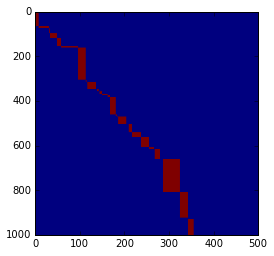

In [36]:
df_fl_a['k'] = 1
df_oge_a_fl['k'] = 1
df_block = df_fl_a.sort_values(by='nzip').iloc[0:1000].merge(df_oge_a_fl.sort_values(by='nzip').iloc[0:500], 
                                                             on='k')[['nzip_x', 'nzip_y']]

z = (df_block.nzip_x == df_block.nzip_y).values
z.shape = (1000, 500)
_=plt.imshow(z, aspect=0.5)

### N-Gram Based Blocks

In [37]:
def window(fseq, window_size=8):
    for i in range(len(fseq) - window_size + 1):
        yield fseq[i:i+window_size]

#Find bigrams and then join them into 8-bigram keys
n1 = ngrams('mainstreet cafe', 2)
[''.join(x) for x in window(n1)]
n2 = ngrams('the main street cafe inc', 2)
# Find the keys shared by these two names
set([''.join(x) for x in window(n1)]) & set([''.join(x) for x in window(n2)])

{'reeeett  ccaaffe', 'sttrreeeett  cca', 'trreeeett  ccaaf'}

### Canopy Clustering

Canopy clustering is a sort of "pre-clustering" used to reduce the number of comparisons needed in more complex clustering algorithms
Generate blocking keys for records in both data sets (for example, n-grams of name)
Build an inverted index (eg, n-gram to list of records with that n-gram)
Repeat
Choose a random record to make a new "canopy"
Look up matching records in inverted index
For each record in index, calculate

## Classifying Matches

We now have numerous tools to match approximately on attributes, so we'll return to the problem of matching items in one set of data to another set.  Remember that in principle we have to check every single pair in the set A x B, which for our test data is about 900M pairs.  Although that's not a huge problem by today's standards, it's still significant and we know that most pairs are not matches, so we seek some way to reduce the number of pairs to test.  Usually this is accomplished by some sort of _indexing_, or in the language of entity resolution _blocking_.  We will discuss blocking later, but usually it involves clustering the candidate items in some way so that each item in set A only needs to be checked against a corresponding cluster in set B.

For the sake of argument, let's say that we can use our normalized zip code as an index, and we'll make a dataframe that has all of the remaining potential matches.  Once we have the zip-indexed dataframe we'll compare the names of the remaining pairs using the Jaro-Winkler similarity, after removing the cases where the names already match exactly.

In [38]:
df_fl_a['snum'] = df_fl_a.location_address.str.split(' ',1).apply(lambda x:x[0])
df_oge_a_fl['snum'] = df_oge_a_fl.street_addr_1_txt.str.split(' ',1).apply(lambda x:x[0])

dfz = df_oge_a_fl.merge(df_fl_a, on='nzip')
dfz_nnm = dfz[dfz.nname_x != dfz.nname_y]
dfz_nm = dfz[dfz.nname_x == dfz.nname_y]
dfz_nnm['score'] = dfz_nnm[['nname_x','nname_y']].apply(lambda p: jellyfish.jaro_winkler(p[0], p[1]), axis=1)

dfz_nnm[dfz_nnm.score>0.9][['nname_x', 
                       'nname_y', 
                       'nzip', 
                       'snum_x',
                       'location_city',
                       'snum_y',
                       'cty_nm',
                       'score']].sort('score',ascending=True).head(10)

/Users/mikemull/anaconda/envs/matching/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mikemull/anaconda/envs/matching/lib/python3.4/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,nname_x,nname_y,nzip,snum_x,location_city,snum_y,cty_nm,score
190603,la pequena columbia restaurant,la pequena colombia espress,33604,6312,TAMPA,6204,Tampa,0.900539
288526,fairfield inn & suites by marriott miami airp,fairfield inn & suites miami south,33126,4101,MIAMI,4101,Miami,0.900776
248225,ciro's speakeasy and restaurant,ciro's speakeasy and supper club,33606,2109,TAMPA,2109,Tampa,0.901540
711593,hooks fish & chicken (miami gardens),hook's fish & chicken,33054,15850,OPA-LOCKA,15850,Miami Gardens,0.901587
704319,katherine's island house cafe,katherine's island house inc,34134,3801,BONITA SPRINGS,3801,Bonita Springs,0.902060
1503336,mcdonalds store # 15535,mcdonald's snack bar #15535,32223,10991-1,JACKSONVILLE,10991,Jacksonville,0.902061
1300441,hunter marine,hunter winter,32615,14700,ALACHUA,15202,Alachua,0.902098
197086,"mikes dockside restaurant, llc",mike's dockside waterfront grille,34667,14333,HUDSON,14333,Hudson,0.902182
313182,subway v,subway 3174,32514,1325,PENSACOLA,8102,Pensacola,0.902273
755271,innisbrook resort and golf club,innisbrook resort & golf club osprey clubhouse,34684,36750,PALM HARBOR,36750,Palm Harbor,0.902384


You can see that there are many businesses that are highly probable matches but don't have identical names (maybe 6 out of 10 in this group of the first 10 with scores > 0.9).   There are two things we can learn from this: one is that we will miss some matches if we rely on exact matches, and the other is that you will rarely find a threshold for any approximate match such that everything is a match.  One of the key problems in matching is finding the most true matches while introducing the least false positives.

The first method that's usually tried is to devise some heuristic score and then treat anything above some value of that score as a match, and anything below some value as a miss.  So for example, we could have a score for this data set that is [(Jaro-Winkler similarity of name) + (1 if zips match) + (1 if street number matches)].  We could say that anything > 2.9 is a match, anything < 2.0 is a non-match, and everything between 2.9 and 2.0 is uncertain (ie, might need a human to look at it).

That heuristic might work adequately in this case (remember, we're ignoring the fact that we could geocode the addresses), but it's difficult to assess the quality of the results since the threshold numbers are essentially guesses.  In other words we know that we'll have false positive matches and false negative misses, but we can't estimate beforehand how likely those errors will be.

### Probabilistic Matching and Fellegi-Sunter

The first rigorous method for finding an optimal set of matches is the Fellegi-Sunter method, which goes back to the 1960s, although it's still in use today.  It was motivated by a need to link records from various data sources collected by the Census Bureau.  Like the heuristic method above, the goals here is to find two threshold levels, T_u and T_l, such that anything above T_u is a positive link, anything below T_l is a positive non_link, and anything between is uncertain.  However, the goal with this method is to be able to set the threshold values such that they meet known (and presumably acceptable) error rates.

In general any two data sets will have some subset of attributes, say &alpha;1 to &alpha;n, on which they could match.  With n attributes there are 2^n patterns of matching.  For example, suppose that in our test data we have only business name, zip code, and street number on which to match.  The patterns are:

In [39]:
pd.DataFrame(data=list(itertools.product(['match','unmatch'], repeat=3)),
             columns=['name', 'zip', 'street num'])

,name,zip,street num
0,match,match,match
1,match,match,unmatch
2,match,unmatch,match
3,match,unmatch,unmatch
4,unmatch,match,match
5,unmatch,match,unmatch
6,unmatch,unmatch,match
7,unmatch,unmatch,unmatch


You can think of each pattern as a separate comparison pattern on a record from A and a record from B.

$$
\gamma(r_{A}, r_{B}) = [ \gamma_{1}(r_{A}, r_{B}), \gamma_{2}(r_{A}, r_{B}), \dots, \gamma_{n}(r_{A}, r_{B})]
$$

where the various &gamma;i can be interpreted as predicates on the comparable attributes of the two records.

If you pick records at random from A and B, you'll end up with a bunch of vectors like those below:

In [40]:
def gamma(ra, rb):
    gg = lambda x: 1 if x else 0
    return [gg(ra[0] == rb[0]), gg(ra[1] == rb[1]), gg(ra[2] == rb[2])]

print(gamma(('tropicana restaurant & lounge', '33012', '1950'), ('pizza hut', '33566', '2316')))
print(gamma(('granger and sons bar-b-que', '33809', '8121'), ('body parts of america', '32534', '8121')))
print(gamma(("antonio's pizzeria restaurant", '33023', '6890'), ('horizon dental care', '33023', '6890')))

[0, 0, 0]
[0, 0, 1]
[0, 1, 1]



Most of the vector patterns will be more common for records that don't match, but some will be more common for records that do match.  You can think of &gamma; as a random variable and the following conditional probabilities can be defined:

$$
\begin{align}
m(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in M] \\
= \sum_{a,b \in M} P[\gamma(r_{A},r_{B})]P[(r_{A}, r_{B}) \in M]
\end{align}
$$
and
$$
\begin{align}
u(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in U] \\
= \sum_{a,b \in U} P[\gamma(r_{A},r_{B}]P[(r_{A}, r_{B}) \in U]
\end{align}
$$

The best patterns for matching will be those that have the largest ratio of m/u.  Suppose that we have two files with 100 records, giving us 100x100=10000 pairs.  Say that all 100 records in each file match.  In 20 cases, the name, zip, and street number are identical.  In 75 cases the zip and street number are the same.  However, in only 2 cases do all attributes match where the records are not a match, but there are 50 cases where the zip and street number match but the record do not match.  Of the remaining 5 matches 4 have the same zip, but 200 non-matches have the same zip.

In [41]:
m_111 = (20/100)
u_111 = (2/9900)
m_011 = (75/100)
u_011 = (50/9900)
m_010 = (4/100)
u_010 = (200/9900)
m_000 = (1/100)
u_000 = (9948/9900)
print(m_111, u_111, m_111/u_111)
print(m_011, u_011, m_011/u_011)
print(m_010, u_010, m_010/u_010)
print(m_000, u_000, m_000/u_000)

0.2 0.00020202020202020202 990.0
0.75 0.005050505050505051 148.5
0.04 0.020202020202020204 1.98
0.01 1.0048484848484849 0.009951749095295536


We can establish what's called a _linkage rule_ by setting the two values &mu; and &lambda;.  In the Fellegi-Sunter method the values are interpreted as:

$$
\mu = P(\mbox{positive link}|U)
$$

$$
\lambda = P(\mbox{positive non-link}|M)
$$

In other words, we set &mu; to the level of false positive we're willing to tolerate, and we set &lambda; to the level of false negatives we will accept.  To relate these values to the m and u values in the Fellegi-Sunter method we first rank the m/u ratios in descending order.  For &mu;, we include patterns in the automatic match part of the rule until the sum of the u values exceeds &mu;.  For &lambda; we choose as many patterns from the end of the list 

For example suppose that we set &mu; = 0.01 indicating that we want at most 1% of false positives in our automatic match set.  If we include the first two of the above patterns, we'll end up with 52 matches for items that are actually in U (sum of u values = 0.0052) but if we include the third pattern we get 252 (sum of u values = 0.0252).  To get a similar level for &lambda; we could only use the final rule to establish positive non-links.  To establish an optimal linkage rule, we can set the upper and lower threshold for matches and non-matches to the m/u ratio for the patterns that meet our &mu; and &lambda; values.  The linkage rule looks like this:

$$
	\begin{array}{ll}
		\frac{m}{u} > T_{\mu}  & \mbox{match}  \\
        T_{\mu} < \frac{m}{u} < T_{\lambda}  & \mbox{potential match}  \\
		\frac{m}{u} < T_{\lambda}  & \mbox{non-match}  \\
	\end{array}
$$

And in this particular case, we can set the threshold values to:

$$
T_{\mu} = m_{011}/u_{011} \\
T_{\lambda} = m_{000}/u_{000}
$$


In practice, _conditional independence_ will be assumed between the attributes so that we can write

$$
Pr(\texttt{name matches}, \texttt{zip matches}, \texttt{street matches}|M)
$$

as the product of probabilities on the individual properties

$$
Pr(\texttt{name matches}|M) Pr(\texttt{zip matches}|M) Pr(\texttt{street matches}|M)
$$

The m and u probabilities can then be written in terms of the individual properties, eg:

$$
m(\texttt{name matches}) = \frac{Pr(\texttt{name matches}|M)}{Pr(\texttt{name matches}|U)}
$$

Now the overall m value for a pair of records (a,b) can be written as:

$$
m = m(\texttt{name matches}) * m(\texttt{zip matches}) * m(\texttt{street matches})
$$

The m/u ratios are usually converted to weights in the following fashion:

$$
w_{i} = 
\left\{
	\begin{array}{ll}
		log_{2}(\frac{m_{i}}{u_{i}})  & \mbox{if agreement on field i}  \\
		log_{2}(\frac{1-m_{i}}{1-u_{i}}) & \mbox{if otherwise}
	\end{array}
\right.
$$


In [48]:
m_u = [('name', 0.95, 0.0000005),
      ('zip', 0.9, 0.001),
      ('snum', 0.9, 0.0003)]
df_mu = pd.DataFrame(data=m_u, columns=['Field', 'm_i', 'u_i'])
df_mu

,Field,m_i,u_i
0,name,0.95,5.000000e-07
1,zip,0.90,1.000000e-03
2,snum,0.90,3.000000e-04


In [49]:
def field_w(a, b, m, u):
    return math.log(m/u, 2) if a == b else math.log((1.0 - m)/(1.0 - u))

def fs_weights(ra, rb, m_u):
    return sum( field_w(ra[i], rb[i], m_u[i][1], m_u[i][2]) for i in range(len(ra)) )


print(fs_weights(('sea siam', '33156', '12735'), ('sea siam', '33156', '12735'), m_u))
print(fs_weights(("antonio's pizzeria restaurant", '33023', '6890'), ('horizon dental care', '33023', '6890'), m_u))
print(fs_weights(('granger and sons bar-b-que', '33809', '8121'), ('body parts of america', '32534', '8121'), m_u))
print(fs_weights(('tropicana restaurant & lounge', '33012', '1950'), ('pizza hut', '33566', '2316'), m_u))

42.22209596448068
18.368796203046415
6.253430419168917
-7.5996014141993715


As you can see the weight decreases rapidly as fewer fields match in each record.

#### The EM Algorithm

Of course, by now you'll be thinking that we don't actually know the m and u values because we don't know if a particular item is in the M set or the U set.  The usual solution to this problem for the Fellegi-Sunter method is the _expectation-maximization_, or __EM__ algorithm.  You can think of the EM algorithm as a sort of unsupervised classification method that's trying, in our case, to place each record pair in either the M class or the U class.

To start we assume that the distribution of matching patterns (our gammas above) is actually a finite mixture of two distributions, defined by the following parameters:

$$
\Phi = ((m_{1}\dots m_{k}), (u_{1}\dots u_{k}), p)
$$

where _m_ and _u_ are vectors of the m and u values, and p is the mixing probability, which here is the probability of a matching record.  [This is similar to the approach taken in _scikit-learn_ Gaussian mixture models, except that these aren't gaussian distributions.] What we want is the _maximum likehood estimate_ of these parameters given the data that we have.  In other words, given the matching patterns that we know (the &gamma;) we want to find the parameters (&phi;) that maximize the likelihood function:

$$
f(\gamma; \Phi)
$$

This is generally an intractable problem though.  For the EM algorithm we also presume the existence of a _latent_ variable _g_ that determines if the record is in the M set or the U set.  Then the likelihood function becomes:

$$
f(g,\gamma; \Phi) = \prod_{j=1}({pP(\gamma_{j}|r_{j} \in M))^g((1-p)P(\gamma_{j}|r_{j} \in U)})^{(1-g)}
$$

The expectation step in the EM algorithm calculates the expected value of the probability that g=1 given an initial set of parameters

$$
E(g|\Phi,R_{ab}) = Pr(g=1|\Phi,R_{ab})
$$

Then the maximization step find new values for the parameters given the calculated values of _g_. This process is repeated until the parameter values stop changing given some threshold.

In [77]:
from matching.fellegi_sunter import fs_em

df_fl_prep = pd.read_csv('./data/fl.restaurant-prep.csv', encoding='utf-8')
df_oge_prep = pd.read_csv('./data/ogesdw.whd-prep.csv', encoding='utf-8')

df1 = df_fl_prep[['nname', 'nzip', 'snum']].sample(frac=0.1)
df2 = df_oge_prep[['nname', 'nzip', 'snum']].sample(frac=0.1)
df1['k'] = 1
df2['k'] = 1
dfz = df_fl_prep.merge(df_oge_prep, on='nzip')
dfz['nzip_x'] = dfz.nzip
dfz['nzip_y'] = dfz.nzip
def gamma_gen(df):
    t1_0 = lambda x: 1 if x else 0
    for idx, r in df.iterrows():
        yield [t1_0(jellyfish.jaro_winkler(r.nname_x, r.nname_y) >= 0.8),
               t1_0(r.nzip_x == r.nzip_y),
               t1_0(r.snum_x == r.snum_y)]

mh, uh, ph = fs_em(df_mu.m_i.values, 
                   df_mu.u_i.values, 
                   1e-6, 
                   gamma_gen(dfz))

[ 0.76457365  1.          0.61210465] [  6.54397179e-06   1.00000000e+00   5.01918632e-03] 0.00288879941267
[ 0.75919505  1.          0.52595576] [  8.49420185e-06   1.00000000e+00   5.25942420e-03] 0.00290670420331
[ 0.75799125  1.          0.50339354] [  9.03716733e-06   1.00000000e+00   5.32324793e-03] 0.00291060629167
[ 0.75768691  1.          0.49742085] [  9.18310549e-06   1.00000000e+00   5.34020061e-03] 0.00291158337847
[ 0.75760723  1.          0.49583748] [  9.22194764e-06   1.00000000e+00   5.34469870e-03] 0.00291183846824
[ 0.75758617  1.          0.4954176 ] [  9.23225850e-06   1.00000000e+00   5.34589177e-03] 0.00291190583527


In [78]:
import numpy as np
print(mh,uh,ph)
print(mh/uh)
print(np.log2(mh/uh))

[ 0.75758617  1.          0.4954176 ] [  9.23225850e-06   1.00000000e+00   5.34589177e-03] 0.00291190583527
[  8.20585961e+04   1.00000000e+00   9.26725835e+01]
[ 16.32436685   0.           6.53407069]


### Supervised Learning

If you have a dataset where some matches and non-matches have already been determined, you can use a standard classifier to develop a model for matching.  This sounds unlikely, but since matching in a commercial setting often involves a team to review matches manually it does happen.

This will usually be a two-class problem (match and non-match), but it could also be a three-class problem (match, non-match, potential match).  As with any classification problem, there are a few things to be careful about.  First, you'll want to get a sample of data that's fairly representative of the full data.  However, if you simply sample some fraction of all possible record pairs, you might get too few match cases.  

In [46]:
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv('./data/match_train.csv')

#Make some new features
df_train['jw_dist'] = df_train[['snum_x', 'snum_y']].apply(
                            lambda s: jellyfish.jaro_winkler(str(s[0]), str(s[1])),
                            axis=1)
df_train['snum_dist'] = df_train[['snum_x', 'snum_y']].apply(
                            lambda s: jellyfish.levenshtein_distance(str(s[0]), str(s[1])),
                            axis=1)
df_train['city_sim'] = df_train[['cty_nm', 'location_city']].apply(
                            lambda c: jaccard_similarity( ngrams(c[0].lower(),2),
                                               ngrams(c[1].lower(),2)),
                                               axis=1)
#Make a balanced data set
df_matched = df_train[df_train.match==1]
df_unmatched = df_train[df_train.match==0]
df_bal = pd.concat( [df_matched, 
                     df_unmatched.sample(len(df_matched)) ] ).reset_index()

In [ ]:
# Do a 5-fold cross-validation
y = df_bal.match
X = df_bal[['jw_dist', 'snum_dist', 'city_sim']].as_matrix()

kf = KFold(len(y),n_folds=5,shuffle=True)
y_pred = y.copy()

clf = RandomForestClassifier()

# Iterate through folds
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
    # Initialize a classifier with key word arguments

    clf.fit(X_train,y_train)
    y_pred[test_index] = clf.predict(X_test)

print(np.mean(y == y_pred))

### Unsupervised and Active Learning

In [ ]:
import dedupe

data_d = {}
df_oge_a_fl[['nname','nzip','snum']]
for idx, t in df_oge_a_fl[['nname','nzip','snum']].iterrows():
    data_d[idx] = t.to_dict()

fields = [
        {'field' : 'nname', 'type': 'String'},
        {'field' : 'nzip', 'type': 'Exact'},
        {'field' : 'snum', 'type': 'Exact'},
        ]

deduper = dedupe.Dedupe(fields)

deduper.sample(data_d, 5000)

In [ ]:
pair = deduper.uncertainPairs()[0]
pd.DataFrame(data=[pair[0].values() + pair[1].values()], columns=['Num1','Name1','Zip1', 'Num2', 'Name2', 'Zip2'])

In [ ]:
deduper.markPairs( {'match':[
                                ({'snum': '1620', 'nname': 'berry holding group - hp', 'nzip': '33527'},
                                 {'snum': '1620', 'nname': 'berry holding group - hp', 'nzip': '33527'}),
                                ({'snum': '936', 'nname': 'st george & the dragon restaurant', 'nzip': '34102'},
                                 {'snum': '936', 'nname': 'st george & the dragon restaurant', 'nzip': '34102'}),
                                ({'snum': '11801', 'nname': 'jnj growers inc', 'nzip': '33187'},
                                 {'snum': '19801', 'nname': 'j n j growers inc', 'nzip': '33187'}))], 
                    'distinct':[
                                ({'snum': 'P.O.', 'nname': 'cruz juan flc', 'nzip': '33862'}, 
                                 {'snum': '1510', 'nname': 'senior bridge', 'nzip': '32901'}),
                                ({'snum': '171', 'nname': 'raul anzualda flc', 'nzip': '32131'}, 
                                 {'snum': '4461', 'nname': 'bee ridge florist', 'nzip': '34233'}),
                                ({'snum': '4332', 'nname': 'advans enterprises', 'nzip': '33317'},
                                 {'snum': '19501', 'nname': 'all day enterprises', 'nzip': '33917'}),
                                ({'snum': '1920', 'nname': 'suggars restaurant and lounge', 'nzip': '33907'},
                                 {'snum': '529', 'nname': 'flavors restaurant and lounge', 'nzip': '34983'}),]
                    })

In [ ]:
deduper.train()
dupes = deduper.match(data_d)
dupes[0]

## Information Quality Metrics for Matching

- Number of References
- Class statistics: size, max
- Talburt-Wang Index
- Rand Index


## References

- [String Metric - Wikipedia](https://en.wikipedia.org/wiki/String_metric)
- ["On the Resemblance and Containment of Documents" - Andrei Broder](http://gatekeeper.dec.com/ftp/pub/dec/SRC/publications/broder/positano-final-wpnums.pdf)
- [_Entity Resolution and Information Quality_ - John R. Talburt](http://www.amazon.com/Entity-Resolution-Information-Quality-Talburt/dp/0123819725)
- Christen, P., & SpringerLink (Online service). (2012). Data matching: Concepts and techniques for record linkage, entity resolution, and duplicate detection. Berlin ; New York: Springer.
- [Data Quality and Record Linkage Techniques](http://www.amazon.com/gp/product/B0016PZT7M)
Thomas N. Herzog, Fritz J. Scheuren, William E. Winkler
-  Fellegi, Ivan; Sunter, Alan (December 1969). "A Theory for Record Linkage" (PDF). Journal of the American Statistical Association 64 (328): pp. 1183–1210. doi:10.2307/2286061. JSTOR 2286061.
- Gregg, Forest and Derek Eder. 2015. Dedupe. https://github.com/datamade/dedupe.
- [Record Linkage in F# – Token Matching, Stable Marriages and the Gale-Shapley algorithm](http://richardminerich.com/2011/09/record-linkage-in-f-token-matching-stable-marriages-and-the-gale-shapley-algorithm/)

In [58]:
df_fl_prep = pd.read_csv('./data/fl.restaurant-prep.csv', encoding='utf-8')

In [52]:
df_fl_prep.columns

Index([u'dba', u'location_address', u'location_city', u'location_zip_code',
       u'nname', u'nzip', u'snum', u'rating', u'lat', u'lon', u'stnum'],
      dtype='object')

In [59]:
type(df_fl_prep.nname[0])

unicode

In [60]:
df_oge_prep = pd.read_csv('./data/ogesdw.whd-prep.csv', encoding='utf-8')
type(df_oge_prep.nname[0])

unicode

In [77]:
import operator
from functools import reduce

def mp(gamma, mh, uh):
    return reduce(operator.mul, (mh[i] ** g * (1 - mh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def up(gamma, mh, uh):
    return reduce(operator.mul, (uh[i] ** g * (1 - uh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def log_score(gamma, mh, uh):
    return sum([np.log2(mh[i]/uh[i]) if g==1 else np.log2((1-mh[i])/(1-uh[i])) for i,g in enumerate(gamma)])

df_scores = pd.DataFrame(data=list(itertools.product([1,0], repeat=3)),
             columns=['name', 'zip', 'street num'])
df_scores['m'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: mp(p,mh,uh), axis=1)
df_scores['u'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: up(p,mh,uh), axis=1)
df_scores['mu'] = df_scores.m/df_scores.u
df_scores['w'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: log_score(p,mh,uh), axis=1)
df_scores.sort('mu', ascending=False, inplace=True)
df_scores['cu'] = df_scores.u.cumsum()
df_scores['cm'] = df_scores.m.cumsum()
df_scores

,name,zip,street num,m,u,mu,w,cu,cm
0,1,1,1,0.077476,1.224100e-10,6.329257e+08,29.237461,1.224100e-10,0.077476
4,0,1,1,0.791982,6.254078e-07,1.266345e+06,20.272239,6.255302e-07,0.869458
1,1,1,0,0.009931,3.882342e-07,2.558027e+04,14.642744,1.013764e-06,0.879389
2,1,0,1,0.001508,6.155908e-08,2.449682e+04,14.580307,1.075323e-06,0.880897
5,0,1,0,0.101518,1.983536e-03,5.118046e+01,5.677521,1.984612e-03,0.982416
6,0,0,1,0.015415,3.145129e-04,4.901273e+01,5.615085,2.299124e-03,0.997831
3,1,0,0,0.000193,1.952401e-04,9.900612e-01,-0.014410,2.494365e-03,0.998024
7,0,0,0,0.001976,9.975056e-01,1.980894e-03,-8.979633,1.000000e+00,1.000000


In [74]:
import numpy as np
df_fl_prep = pd.read_csv('./data/fl.restaurant-prep.csv')
df_oge_prep = pd.read_csv('./data/ogesdw.whd-prep.csv')
dfz = df_fl_prep.merge(df_oge_prep, on='nzip')
mh = np.array([ 0.08910887,  0.98090761,  0.88638131])
uh = np.array([ 0.00019569,  0.00198455,  0.0003152 ])


In [78]:
def gamma_pattern(r_ab):
    t1_0 = lambda x: 1 if x else 0
#    return [1 if a_i == b_i else 0 for (a_i, b_i) in zip(r_ab[0], r_ab[1])]
    return [t1_0(jellyfish.jaro_winkler(r_ab[0][0], r_ab[1][0]) > 0.9),
            t1_0(r_ab[0][1] == r_ab[1][1]),
            t1_0(r_ab[0][2] == r_ab[1][2])]

def score(r):
    return log_score(gamma_pattern((r[0:3], r[3:])), mh, uh)

dfz['fss'] = dfz[['nname_x', 'nzip', 'snum_x', 'nname_y', 'nzip', 'snum_y']].apply(score, axis=1)


In [73]:
dfz[dfz.fss>21.0].sort('fss')[['dba','location_address', 'location_city', 'trade_nm', 'street_addr_1_txt', 'cty_nm', 'fss']].head(20)

,dba,location_address,location_city,trade_nm,street_addr_1_txt,cty_nm,fss
484,LATIN AMERICAN CAFETERIA,401 BISCAYNE BLVD,MIAMI,Latin American Cafeteria at Bayside,401 Biscayne Blvd.,Miami,29.237461
818921,MCDONALDS,100 S NOVA RD,ORMOND BCH,McDonald's,100 Nova Road,Ormond Beach,29.237461
819010,ROCKIN RANCH,801 S NOVA RD,ORMOND BCH,Rockin' Ranch,801 S Nova Road,Ormond Beach,29.237461
820428,PRESTWICK GOLF CLUB,1044 HAMPSTEAD LN,ORMOND BCH,Prestwick Golf Club at Plantation Bay,1044 Hampstead Land,Ormond Beach,29.237461
822439,MARIA BONITA RESTAURANT,195 W GRANADA BLVD,ORMOND BEACH,Maria Bonita Mexican Restaurant,195 W. Granada Blvd,Ormond Beach,29.237461
824722,PANTHEON PIZZA,505 WHITE ST,DAYTONA BEACH,Pantheon Pizza,505 White Street,Daytona Beach,29.237461
825318,LARRYS GIANT SUBS,1500 BEVILLE RD,DAYTONA BEACH,Larry's Giant Subs,"1500 Beville Road, Suite 604",Daytona Beach,29.237461
826845,HILTON GARDEN INN RESTAURANT,189 MIDWAY AVE,DAYTONA BCH,Hilton Garden Inn,189 Midway Ave,Daytona Beach,29.237461
826971,CHURCH'S CHICKEN,988 ORANGE AVE,DAYTONA BEACH,Church's Chicken,988 Orange Avenue,Daytona Beach,29.237461
827376,HALIFAX RIVER YACHT CLUB,331 SOUTH BEACH STREET,DAYTONA BEACH,Halifax River Yacht Club,331 South Beach Street,Daytona Beach,29.237461


In [67]:
uh

array([ 0.00019569,  0.00198455,  0.0003152 ])

In [69]:
(1-uh[0])**0 * uh[1]**1 * uh[2]**1

6.2553016000000001e-07

In [79]:
dfz['match'] = dfz.fss.apply(lambda x: 1 if x > 21.0 else 0)

In [80]:
len(dfz)

1100114

In [81]:
dfz.to_csv('./data/matches.csv')

In [43]:
df_train.head()

,nname_x,nname_y,snum_x,snum_y,location_city,cty_nm,match,jw_dist
0,"marrtinez, arturo harvesting, inc.",a&g soul food truck,221,529,HOMESTEAD,Homestead,0,0.555556
1,"marrtinez, arturo harvesting, inc.","bangkok cuisine, inc.",221,45,HOMESTEAD,Homestead,0,0.000000
2,"marrtinez, arturo harvesting, inc.",big pig bbq inc,221,19705,HOMESTEAD,Homestead,0,0.000000
3,"marrtinez, arturo harvesting, inc.",bobbie jo's & friends,221,1320,HOMESTEAD,Homestead,0,0.527778
4,"marrtinez, arturo harvesting, inc.",casavana cuban cuisine,221,2814,HOMESTEAD,Homestead,0,0.722222


In [49]:
df_bal.to_csv('./data/balanced_train.csv', index=False, encoding='utf-8')

In [45]:
df_oge_a_fl[['nname','sndx']]

,nname,sndx
0,biel performance boats llc,B416
1,blu grotto,B426
2,body parts of america,B316
3,embarq,E516
4,murton roofing,M635
5,northwest airlines,N632
6,mcdonald's,M235
7,u.s. post office,U212
8,wakulla urgent care,W246
9,signature towers construction,S253


In [58]:
x=gamma_gen(df1.merge(df2, on='k'))

In [64]:
dfs=df1.merge(df2, on=['nzip', 'snum'])
dfs.columns

Index(['nname_x', 'nzip', 'snum', 'k_x', 'nname_y', 'k_y'], dtype='object')

In [66]:
dfs['jw'] = dfs[['nname_x','nname_y']].apply(lambda x: jellyfish.jaro_winkler(x[0], x[1]), axis=1)

In [72]:
dfs

,nname_x,nzip,snum,k_x,nname_y,k_y,jw
0,evie tavern on the range,34233,4735,1,1223 parking inc,1,0.486111
1,the pierre pizza,32073,1910,1,cinnabon,1,0.395833
2,a&d bufalos,32073,1910,1,cinnabon,1,0.549242
3,subway #30952,33607,2223,1,gcs wireless,1,0.382479
4,subway #30952,33607,2223,1,bar louie,1,0.417379
5,bar louie,33607,2223,1,gcs wireless,1,0.524074
6,bar louie,33607,2223,1,bar louie,1,1.000000
7,cheesecake factory (the),33607,2223,1,gcs wireless,1,0.472222
8,cheesecake factory (the),33607,2223,1,bar louie,1,0.370370
9,brio tuscan grille,33607,2223,1,gcs wireless,1,0.562169


In [73]:
12/69

0.17391304347826086